In [ ]:
!pip install emnist

In [ ]:
import numpy as np
from keras.layers import *
from keras.models import Model, load_model
from keras import backend as K
from keras import losses
from keras.optimizers import SGD,Adam
import imageio,os
from PIL import Image
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from emnist import extract_training_samples, extract_test_samples
from keras.regularizers import l1, l2

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
batch_size = 100
latent_dim = 20
epochs = 100
img_dim = 28
filters = 16
intermediate_dim = 256
learning_rate = 0.005
#momentum = 0.5
#dataset = 'balanced'
#dataset = 'letters'
#dataset = 'mnist'
dataset = 'fashion'

In [ ]:
if dataset == 'balanced':
  num_classes = 47
  x_train, y_train = extract_training_samples(dataset)
  x_test, y_test = extract_test_samples(dataset)
elif dataset == 'letters':
  num_classes = 26
  x_train, y_train = extract_training_samples(dataset)
  x_test, y_test = extract_test_samples(dataset)
elif dataset == 'mnist':
  num_classes = 10
  from keras.datasets import mnist
  (x_train, y_train), (x_test, y_test) = mnist.load_data()
elif dataset == 'fashion':
  num_classes = 10
  from keras.datasets import fashion_mnist as mnist
  (x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((-1, img_dim, img_dim, 1))
x_test = x_test.reshape((-1, img_dim, img_dim, 1))

In [ ]:
# 搭建模型
x = Input(shape=(img_dim, img_dim, 1))
h = x
h = Flatten()(h)

# Add dense layers
for i in range(4):  # Increase the number of layers
    h = Dense(2 * intermediate_dim)(h)
    h = LeakyReLU(0.2)(h)
    h = BatchNormalization()(h)  # Add batch normalization

h_shape = K.int_shape(h)[1:]
z_mean = Dense(latent_dim)(h) # p(z|x)的均值
z_log_var = Dense(latent_dim)(h) # p(z|x)的方差

encoder = Model(x, z_mean) # 通常认为z_mean就是所需的隐变量编码

z = Input(shape=(latent_dim,))
h = z

# 搭建模型
# x = Input(shape=(img_dim, img_dim, 1))
# h = x

# h = Conv2D(filters=filters, kernel_size=3, strides=2, padding='same')(h)
# h = LeakyReLU(0.2)(h)
# h = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(h)
# h = LeakyReLU(0.2)(h)
# h = Conv2D(filters=filters*2, kernel_size=3, strides=2, padding='same')(h)
# h = LeakyReLU(0.2)(h)
# h = Conv2D(filters=filters*2, kernel_size=3, strides=1, padding='same')(h)
# h = LeakyReLU(0.2)(h)

# h_shape = K.int_shape(h)[1:]
# h = Flatten()(h)
# z_mean = Dense(latent_dim)(h) # p(z|x)的均值
# z_log_var = Dense(latent_dim)(h) # p(z|x)的方差

# encoder = Model(x, z_mean) # 通常认为z_mean就是所需的隐变量编码

In [ ]:
# Add dense layers
for i in range(4):  # Increase the number of layers
    h = Dense(2 * intermediate_dim)(h)
    h = LeakyReLU(0.2)(h)
    h = BatchNormalization()(h)  # Add batch normalization

h = Dense(img_dim * img_dim, activation='sigmoid')(h)
x_recon = Reshape((img_dim, img_dim, 1))(h)

decoder = Model(z, x_recon) # 解码器
generator = decoder
# z = Input(shape=(latent_dim,))
# h = z
# h = Dense(np.prod(h_shape))(h)
# h = Reshape(h_shape)(h)

# # Mirroring VGG-5 based encoder structure
# h = Conv2DTranspose(filters=filters*2, kernel_size=3, strides=1, padding='same')(h)
# h = LeakyReLU(0.2)(h)
# h = Conv2DTranspose(filters=filters*2, kernel_size=3, strides=2, padding='same')(h)
# h = LeakyReLU(0.2)(h)
# h = Conv2DTranspose(filters=filters, kernel_size=3, strides=1, padding='same')(h)
# h = LeakyReLU(0.2)(h)
# h = Conv2DTranspose(filters=filters, kernel_size=3, strides=2, padding='same')(h)
# h = LeakyReLU(0.2)(h)

# x_recon = Conv2DTranspose(filters=1,
#               kernel_size=3,
#               activation='sigmoid',
#               padding='same')(h)


# decoder = Model(z, x_recon) # 解码器
# generator = decoder

In [ ]:
z = Input(shape=(latent_dim,))
y = Dense(intermediate_dim, activation='relu')(z)
y = Dense(num_classes, activation='softmax')(y)

classfier = Model(z, y) # 隐变量分类器

In [ ]:
# 重参数技巧
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# 重参数层，相当于给输入加入噪声
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
x_recon = decoder(z)
y = classfier(z)

In [ ]:
class Gaussian(Layer):
    """这是个简单的层，定义q(z|y)中的均值参数，每个类别配一个均值。
    然后输出“z - 均值”，为后面计算loss准备。
    """
    def __init__(self, num_classes, **kwargs):
        self.num_classes = num_classes
        super(Gaussian, self).__init__(**kwargs)
    def build(self, input_shape):
        latent_dim = input_shape[-1]
        self.mean = self.add_weight(name='mean',
                       shape=(self.num_classes, latent_dim),
                       initializer='zeros')
    def call(self, inputs):
        z = inputs # z.shape=(batch_size, latent_dim)
        z = K.expand_dims(z, 1)
        return z - K.expand_dims(self.mean, 0)
    def compute_output_shape(self, input_shape):
        return (None, self.num_classes, input_shape[-1])

gaussian = Gaussian(num_classes)
z_prior_mean = gaussian(z)

In [ ]:
# 建立模型
vae = Model(x, [x_recon, z_prior_mean, y])

In [ ]:
# 下面一大通都是为了定义loss
z_mean = K.expand_dims(z_mean, 1)
z_log_var = K.expand_dims(z_log_var, 1)

lamb = 1 # 这是重构误差的权重，它的相反数就是重构方差，越大意味着方差越小。
xent_loss = 0.5 * K.mean((x - x_recon)**2, 0) # 重构误差（Reconstruction Error）
#xent_loss = losses.binary_crossentropy(x, x_recon)
kl_loss = - 0.5 * (z_log_var - K.square(z_prior_mean))
kl_loss = K.mean(K.batch_dot(K.expand_dims(y, 1), kl_loss), 0) # KL散度（KL Divergence）
cat_loss = K.mean(y * K.log(y + K.epsilon()), 0) # 分类误差（Classification Error）
vae_loss = lamb * K.sum(xent_loss) + K.sum(kl_loss) + K.sum(cat_loss) # 最后，这三部分的损失函数加权求和，得到总的损失函数，损失函数的值越小越好



vae.add_loss(vae_loss)
# optimizer = SGD(lr=learning_rate, momentum=momentum)
#adam_optimizer = Adam(learning_rate=0.005)
vae.compile(optimizer='adam') #Keras 的 Adam 优化器来训练模型
vae.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten_7 (Flatten)            (None, 784)          0           ['input_19[0][0]']               
                                                                                                  
 dense_46 (Dense)               (None, 512)          401920      ['flatten_7[0][0]']              
                                                                                                  
 leaky_re_lu_44 (LeakyReLU)     (None, 512)          0           ['dense_46[0][0]']               
                                                                                           

In [ ]:
file_name = 'vae_vgg5_' + dataset + '_sgd_lr_' + str(learning_rate) + '_' + str(epochs) +'.h5'
print(file_name)

vae_vgg5_fashion_sgd_lr_0.005_100.h5


313/313 [==============================] - 1s 2ms/step


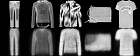

313/313 [==============================] - 0s 2ms/step


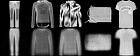

313/313 [==============================] - 0s 2ms/step


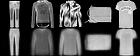

313/313 [==============================] - 0s 2ms/step


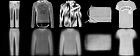

313/313 [==============================] - 0s 2ms/step


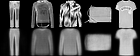

313/313 [==============================] - 1s 2ms/step


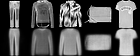

313/313 [==============================] - 1s 2ms/step


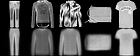

313/313 [==============================] - 1s 2ms/step


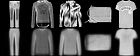

313/313 [==============================] - 1s 2ms/step


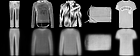

313/313 [==============================] - 1s 2ms/step


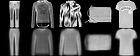

600/600 [==============================] - 7s 11ms/step - loss: 22.5222 - val_loss: 22.2962


In [ ]:
if not os.path.exists('compare'):
    os.mkdir('compare')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
checkpoint_callback = ModelCheckpoint(
    filepath = file_name,  # 模型保存路径
    save_freq='epoch',  # 保存频率为每个epoch
    period=10  # 每隔10个epoch保存一次模型
)

callbacks = [early_stopping, reduce_lr]


for i in range(epochs):
  vae.fit(x_train,
      shuffle=True,
      epochs=1,
      batch_size=batch_size,
      validation_data=(x_test, None))
      #callbacks=callbacks)

  if i % 10 == 0:
        x_test_encoded = encoder.predict(x_test)
        recon = generator.predict(x_test_encoded)
        n = 5  # change this line to adjust the number of images
        fig = np.zeros((img_dim * 2, img_dim * n))
        for m in range(15, 20):  # change this line
            x_test_origin = x_test[m].reshape((img_dim, img_dim))
            fig[0 * img_dim: (0 + 1) * img_dim,
                (m - 15) * img_dim: ((m - 15) + 1) * img_dim] = x_test_origin  # change this line

            x_test_generate = recon[m].reshape((img_dim, img_dim))
            fig[1 * img_dim: (1 + 1) * img_dim,
                (m - 15) * img_dim: ((m - 15) + 1) * img_dim] = x_test_generate  # change this line

            fit_path = './compare/epoch' + str(i) + '_compare.png'
            imageio.imwrite(fit_path, fig * 255)

        # 将numpy数组转换为PIL Image对象
        fig_pil = Image.fromarray((fig * 255).astype(np.uint8))

        # 显示图像
        display(fig_pil)

# 将模型保存到文件
vae.save(file_name)

In [ ]:
means = K.eval(gaussian.mean)
x_train_encoded = encoder.predict(x_train)
y_train_pred = classfier.predict(x_train_encoded).argmax(axis=1)
x_test_encoded = encoder.predict(x_test)
y_test_pred = classfier.predict(x_test_encoded).argmax(axis=1)

313/313 [==============================] - 0s 1ms/step


In [ ]:
def cluster_sample(path, category=0):
    """观察被模型聚为同一类的样本
    """
    n = 8
    figure = np.zeros((img_dim * n, img_dim * n))
    idxs = np.where(y_train_pred == category)[0]
    for i in range(n):
        for j in range(n):
            digit = x_train[np.random.choice(idxs)]
            digit = digit.reshape((img_dim, img_dim))
            figure[i * img_dim: (i + 1) * img_dim,
            j * img_dim: (j + 1) * img_dim] = digit
    imageio.imwrite(path, figure * 255)

In [ ]:
def random_sample(path, category=0, std=1):
    """按照聚类结果进行条件随机生成
    """
    n = 8
    figure = np.zeros((img_dim * n, img_dim * n))
    for i in range(n):
        for j in range(n):
            noise_shape = (1, latent_dim)
            z_sample = np.array(np.random.randn(*noise_shape)) * std + means[category]
            x_recon = generator.predict(z_sample)
            digit = x_recon[0].reshape((img_dim, img_dim))
            figure[i * img_dim: (i + 1) * img_dim,
            j * img_dim: (j + 1) * img_dim] = digit
    imageio.imwrite(path, figure * 255)

In [ ]:
if not os.path.exists('samples'):
    os.mkdir('samples')

for i in range(10):
    cluster_sample(u'samples/聚类类别_%s.png' % i, i)
    random_sample(u'samples/类别采样_%s.png' % i, i)

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


In [ ]:
right = 0.
for i in range(10):
    _ = np.bincount(y_train[y_train_pred == i])
    right += _.max()

print (f'train acc: {right / len(y_train)}')


right = 0.
for i in range(10):
    _ = np.bincount(y_test[y_test_pred == i])
    right += _.max()

print (f'test acc: {right / len(y_test)}')

train acc: 0.5750833333333333
test acc: 0.5762


In [ ]:
from sklearn.metrics import adjusted_rand_score, mutual_info_score
from sklearn.metrics import fowlkes_mallows_score
# Calculate ARI
ari_train = adjusted_rand_score(y_train, y_train_pred)
ari_test = adjusted_rand_score(y_test, y_test_pred)
# Calculate Mutual Information
mi_train = mutual_info_score(y_train, y_train_pred)
mi_test = mutual_info_score(y_test, y_test_pred)
# Fowlkes-Mallows Index (FMI)
score_train = fowlkes_mallows_score(y_train, y_train_pred)
score_test = fowlkes_mallows_score(y_test, y_test_pred)

print("ARI for Training Set:", ari_train)
print("ARI for Test Set:", ari_test)
print("Mutual Information for Training Set:", mi_train)
print("Mutual Information for Test Set:", mi_test)
print("Fowlkes-Mallows Index for Training Set:", score_train)
print("Fowlkes-Mallows Index for Test Set:", score_test)

ARI for Training Set: 0.3977350667487504
ARI for Test Set: 0.396625312345602
Mutual Information for Training Set: 1.2180682935500013
Mutual Information for Test Set: 1.214110787650136
Fowlkes-Mallows Index for Training Set: 0.4585121141747862
Fowlkes-Mallows Index for Test Set: 0.4574762261024934


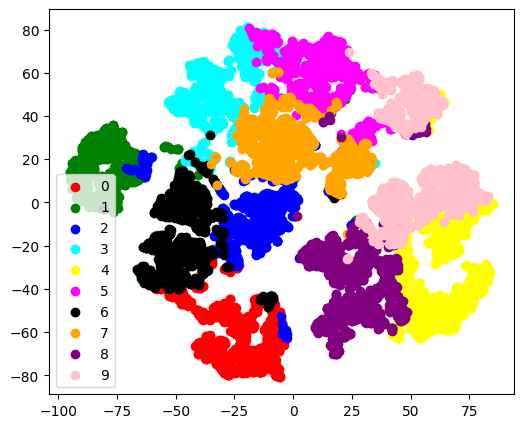

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
x_test_2d = tsne.fit_transform(x_test_encoded)

plt.figure(figsize=(6, 5))
colors = "red", "green", "blue", "cyan", "yellow", "magenta", "black", "orange", "purple", "pink"
for i, c, label in zip(range(num_classes), colors, range(num_classes)):
    plt.scatter(x_test_2d[y_test_pred == i, 0], x_test_2d[y_test_pred == i, 1], c=c, label=label)
plt.legend()
plt.show()